<!--COURSE_INFORMATION-->
*This notebook contains material from [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Job Shop Scheduling](04.02-Job-Shop-Scheduling.ipynb) | [Contents](index.ipynb) | [Scheduling Multipurpose Batch Processes using State-Task Networks](04.04-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Maintenance-Planning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Maintenance Planning

## Problem Statement


A factory is operating over a maintenance planning horizon from $1$ to $T$ days.  On day $t$ the factory makes a profit $c[t]$ which is known in advance. The factory needs to shut down for $P$ maintenance periods during the planning period.  Once started, a maintenance period takes $M$ days to finish.

Find a maintenance schedule that allows the maximum profit to be produced.

## Modeling

The model is comprised of two sets of the binary variables indexed 1 to $T$. Binary variables $x_t$ correspond to the operating mode of the factory, with $x_t=1$ indicating the factory is operating on day $t$ and able to earn a profit $c_t$. Binary variable $y_t=1$ indicates the first day of a maintenance period during which the factory is not operating and earning $0$ profit.

### Objective

The planning objective is to maximize profit

\begin{align*}
\mbox{Profit} & = \max_{x, y} \sum_{t=1}^T c_t x_t
\end{align*}

subject to completing $P$ maintenance periods.  

### Constraints

#### Number of planning periods is equal to P.

Completing $P$ planning periods requires

\begin{align*}
\sum_{t=1}^T y_t &  = P \\
\end{align*}

#### No more than one maintenance period can start in any consecutive set of M days.

No more than one maintenance period can start in any consecutive set of M days.

\begin{align*}
\sum_{s=0}^{M-1}y_{t+s} & \leq 1 \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}

This last requirement could be modified if some period of time should occur between maintenance periods.

#### The factory must shut down for M days following a maintenance start.

The final requirement is a disjunctive constraint that says either $y_t = 0$ or the sum $\sum_{s}^{M-1}x_{t+s} = 0$, but not both. Mathematically, this forms a set of constraints reading

\begin{align*}
\left(y_t = 0\right) \lor \left(\sum_{s=0}^{M-1}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}

where $\lor$ denotes a disjunction.

These disjunctive constraints can be implemented using the big-M method.  In particular,

\begin{align*}
\sum_{s=0}^{M-1}x_{t+s} \leq M(1-y_t) \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}

Alternatively, the disjunctive constraints can be represented directly in Pyomo using the [Generalized Disjunctive Programming](https://pyomo.readthedocs.io/en/latest/modeling_extensions/gdp.html) extension. The advantage of using the extension is that constraints can be transformed to an MILP using alternatives to the big-M, such as convex hull and cutting plane methods.


## Pyomo Solution

### Initialization for Google Colaboratory

Run the following cell to install the Pyomo and the COIN-OR CBC solver needed to execute the code in this notebook.

In [0]:
%%capture
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

### Parameter Values

In [0]:
import numpy as np

# problem parameters
T = 31        # planning period from 1..T
M = 3         # length of maintenance period
P = 4         # number of maintenance periods

# daily profits
c = {k:np.random.uniform() for k in range(1, T+1)}

### Pyomo Model using Big-M

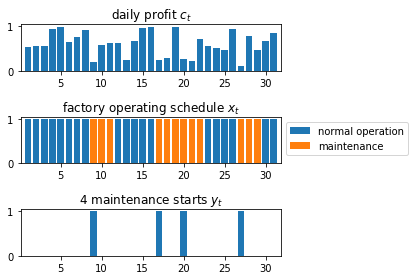

In [3]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt

def maintenance_planning_gdp(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T-M+1)
    m.S = pyo.RangeSet(0, M-1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.T, domain=pyo.Binary)

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)

    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)

    # disjunctive constraints
    m.disj = pyo.Constraint(m.Y, m.S, rule = lambda m, t, s: sum(m.x[t+s] for s in m.S) <= M*(1 - m.y[t]))
    
    return m
 
def plot_schedule(m):
    fig,ax = plt.subplots(3,1)
    
    ax[0].bar(m.T, [m.c[t] for t in m.T])
    ax[0].set_title('daily profit $c_t$')
    
    ax[1].bar(m.T, [m.x[t]() for t in m.T], label='normal operation')
    ax[1].bar(m.T, [1-m.x[t]() for t in m.T], label='maintenance')
    ax[1].set_title('factory operating schedule $x_t$')
    ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    
    ax[2].bar(m.Y, [m.y[t]() for t in m.Y])
    ax[2].set_title(str(P) + ' maintenance starts $y_t$')
    for a in ax:
        a.set_xlim(0.1, len(m.T)+0.9)
  
m = maintenance_planning_gdp(c, T, M, P)
pyo.SolverFactory('cbc').solve(m)
plot_schedule(m)

plt.tight_layout()

### Pyomo Model using the Generalized Disjunctive Programming Extension

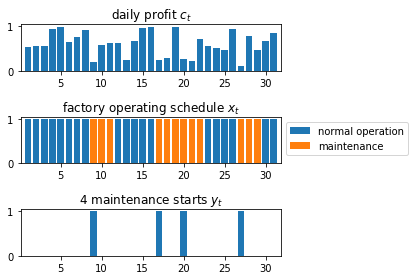

In [4]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import matplotlib.pyplot as plt

def maintenance_planning_gdp(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T-M+1)
    m.S = pyo.RangeSet(0, M-1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.T, domain=pyo.Binary)

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)

    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)

    # disjunctive constraints
    m.disj = gdp.Disjunction(m.Y, m.S, rule = lambda m, t, s: [m.y[t]==0, sum(m.x[t+s] for s in m.S)==0])

    # transformation and soluton
    pyo.TransformationFactory('gdp.chull').apply_to(m)
    
    return m
 
def plot_schedule(m):
    fig,ax = plt.subplots(3,1)
    
    ax[0].bar(m.T, [m.c[t] for t in m.T])
    ax[0].set_title('daily profit $c_t$')
    
    ax[1].bar(m.T, [m.x[t]() for t in m.T], label='normal operation')
    ax[1].bar(m.T, [1-m.x[t]() for t in m.T], label='maintenance')
    ax[1].set_title('factory operating schedule $x_t$')
    ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    
    ax[2].bar(m.Y, [m.y[t]() for t in m.Y])
    ax[2].set_title(str(P) + ' maintenance starts $y_t$')
    for a in ax:
        a.set_xlim(0.1, len(m.T)+0.9)
  
m = maintenance_planning_gdp(c, T, M, P)
pyo.SolverFactory('cbc').solve(m)
plot_schedule(m)

plt.tight_layout()

## Exercise

Rather than specify how many maintenance periods must be accomodated, modify the model so that factory can operate no more than $N$ days without a maintenance shutdown.  (Hint. You may to introduce an additional set of binary variables, $z_t$ to denote the start of an operational period.)

<!--NAVIGATION-->
< [Job Shop Scheduling](04.02-Job-Shop-Scheduling.ipynb) | [Contents](index.ipynb) | [Scheduling Multipurpose Batch Processes using State-Task Networks](04.04-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Maintenance-Planning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
